# Dependencies

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import numpy as np

# Data Preparation

In [2]:
class LowLightDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.image_names = os.listdir(input_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        input_path = os.path.join(self.input_dir, img_name)
        target_path = os.path.join(self.target_dir, img_name)
        
        input_image = Image.open(input_path).convert("RGB")
        target_image = Image.open(target_path).convert("RGB")
        
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
        
        return input_image, target_image
    

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Paths to the input and target directories
input_dir = '/kaggle/input/lol-dataset/lol_dataset/our485/low'
target_dir = '/kaggle/input/lol-dataset/lol_dataset/our485/high'

# Create dataset and dataloader
dataset = LowLightDataset(input_dir=input_dir, target_dir=target_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
input_dir = '/kaggle/input/lol-dataset/lol_dataset/eval15/low'
target_dir = '/kaggle/input/lol-dataset/lol_dataset/eval15/high'

t_dataset = LowLightDataset(input_dir=input_dir, target_dir=target_dir, transform=transform)
t_dataloader = DataLoader(t_dataset, batch_size=1, shuffle=True)


# Loss functions  and Metrics 

In [4]:
class CombinedL1MSELoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedL1MSELoss, self).__init__()
        self.alpha = alpha
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
    
    def forward(self, pred, target):
        # Resize pred to match target size if necessary    
        l1 = self.l1_loss(pred, target)
        mse = self.mse_loss(pred, target)
        return l1 + self.alpha * mse

In [5]:
class ColorLoss(nn.Module):
    def forward(self, output, target):
        return torch.mean((output - target) ** 2)


In [6]:
vgg = torchvision.models.vgg16(pretrained=True).features

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 63.5MB/s] 


In [7]:
class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg
        self.feature_layers = feature_layers
        self.criterion = nn.MSELoss()

    def forward(self, output, target):
        loss = 0
        for layer in self.feature_layers:
            output_features = self.vgg[:layer](output)
            target_features = self.vgg[:layer](target)
            loss += self.criterion(output_features, target_features)
        return loss


In [8]:
# PSNR function
def calculate_psnr(output_img, target_img):
    mse = F.mse_loss(output_img, target_img)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Models 

In [9]:
# MODIFIED AMPLIFIED UNET USING INTERPOLATE INSTEAD OF TRANSPOSE TO UPCONVOLVE 
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, amplification_factor=100):
        super(UNet, self).__init__()
        self.amplification_factor = amplification_factor
        
        def block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = block(in_channels, 64)
        self.encoder2 = block(64, 128)
        self.encoder3 = block(128, 256)
        
        self.pool = nn.MaxPool2d(2)
        
        self.middle = block(256, 512)
        
        self.upconv3 = nn.Conv2d(512, 256, kernel_size=1)
        self.decoder3 = block(512, 256)
        self.upconv2 = nn.Conv2d(256, 128, kernel_size=1)
        self.decoder2 = block(256, 128)
        self.upconv1 = nn.Conv2d(128, 64, kernel_size=1)
        self.decoder1 = block(128, 64)
        
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Apply amplification factor
        x = x * self.amplification_factor
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        
        middle = self.middle(self.pool(enc3))
        
        dec3 = F.interpolate(middle, scale_factor=2, mode='bilinear', align_corners=True)
        dec3 = self.center_crop(enc3, dec3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True)
        dec2 = self.center_crop(enc2, dec2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=True)
        dec1 = self.center_crop(enc1, dec1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        y = self.out_conv(dec1)
#         y = y * amplification_factor
        return y
    
    def center_crop(self, enc, dec):
        _, _, H, W = enc.size()
        _, _, h, w = dec.size()
        x1 = (W - w) // 2
        y1 = (H - h) // 2
        return enc[:, :, y1:y1+h, x1:x1+w]


In [10]:
def train(model, dataloader, optimizer, device, num_epochs=1):
    model.train()
    color_loss = ColorLoss().to(device)
    perceptual_loss = PerceptualLoss(feature_layers=[3, 8, 15]).to(device)
    l1_loss = nn.L1Loss().to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        running_loss_color = 0.0
        running_loss_perceptual = 0.0
        running_loss_l1 = 0.0
        running_total_loss = 0.0

        for i, data in enumerate(dataloader, 1):
            input_images, target_images = data
            input_images, target_images = input_images.to(device), target_images.to(device)

            optimizer.zero_grad()

            # Forward pass
            output_images = model(input_images)

            # Calculate losses
            loss_color = color_loss(output_images, target_images)
            loss_perceptual = perceptual_loss(output_images, target_images)
            loss_l1 = l1_loss(output_images, target_images)

            total_loss = loss_color + 0.1*loss_perceptual + 5*loss_l1
            total_loss.backward()
            optimizer.step()

            # Accumulate loss for this batch
            running_loss_color += loss_color.item()
            running_loss_perceptual += loss_perceptual.item()
            running_loss_l1 += loss_l1.item()
            running_total_loss += total_loss.item()

        # Print epoch summary
        print(f"Epoch {epoch+1} Summary - "
              f"Color Loss: {running_loss_color/len(dataloader):.4f}, "
              f"Perceptual Loss: {running_loss_perceptual/len(dataloader):.4f}, "
              f"L1 Loss: {running_loss_l1/len(dataloader):.4f}, "
              f"Total Loss: {running_total_loss/len(dataloader):.4f}")

    print("Training complete.")


In [10]:
device = 'cuda'

In [11]:
# Example usage
model = UNet(in_channels=3, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
model.load_state_dict(torch.load('/kaggle/input/final-model/best_final_unet_final.pth'))


<All keys matched successfully>

In [13]:
train(model, dataloader, optimizer, device,num_epochs=10)

Epoch 1/10
Epoch 1 Summary - Color Loss: 0.0722, Perceptual Loss: 7.7915, L1 Loss: 0.1936, Total Loss: 1.8194
Epoch 2/10
Epoch 2 Summary - Color Loss: 0.0404, Perceptual Loss: 5.7555, L1 Loss: 0.1445, Total Loss: 1.3382
Epoch 3/10
Epoch 3 Summary - Color Loss: 0.0366, Perceptual Loss: 5.6323, L1 Loss: 0.1442, Total Loss: 1.3207
Epoch 4/10
Epoch 4 Summary - Color Loss: 0.0296, Perceptual Loss: 5.2705, L1 Loss: 0.1323, Total Loss: 1.2183
Epoch 5/10
Epoch 5 Summary - Color Loss: 0.0288, Perceptual Loss: 5.0360, L1 Loss: 0.1301, Total Loss: 1.1827
Epoch 6/10
Epoch 6 Summary - Color Loss: 0.0279, Perceptual Loss: 4.7169, L1 Loss: 0.1275, Total Loss: 1.1370
Epoch 7/10
Epoch 7 Summary - Color Loss: 0.0266, Perceptual Loss: 4.6142, L1 Loss: 0.1270, Total Loss: 1.1229
Epoch 8/10
Epoch 8 Summary - Color Loss: 0.0250, Perceptual Loss: 4.5239, L1 Loss: 0.1237, Total Loss: 1.0959
Epoch 9/10
Epoch 9 Summary - Color Loss: 0.0256, Perceptual Loss: 4.4675, L1 Loss: 0.1254, Total Loss: 1.0991
Epoch 10/1

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [32]:
train(model, dataloader, optimizer, device,num_epochs=20)

Epoch 1/20
Epoch 1 Summary - Color Loss: 0.0221, Perceptual Loss: 3.6674, L1 Loss: 0.1172, Total Loss: 0.9748
Epoch 2/20
Epoch 2 Summary - Color Loss: 0.0221, Perceptual Loss: 3.6573, L1 Loss: 0.1172, Total Loss: 0.9739
Epoch 3/20
Epoch 3 Summary - Color Loss: 0.0219, Perceptual Loss: 3.6699, L1 Loss: 0.1165, Total Loss: 0.9715
Epoch 4/20
Epoch 4 Summary - Color Loss: 0.0219, Perceptual Loss: 3.6566, L1 Loss: 0.1165, Total Loss: 0.9698
Epoch 5/20
Epoch 5 Summary - Color Loss: 0.0219, Perceptual Loss: 3.6756, L1 Loss: 0.1167, Total Loss: 0.9729
Epoch 6/20
Epoch 6 Summary - Color Loss: 0.0216, Perceptual Loss: 3.6689, L1 Loss: 0.1159, Total Loss: 0.9679
Epoch 7/20
Epoch 7 Summary - Color Loss: 0.0216, Perceptual Loss: 3.6734, L1 Loss: 0.1158, Total Loss: 0.9678
Epoch 8/20
Epoch 8 Summary - Color Loss: 0.0216, Perceptual Loss: 3.6595, L1 Loss: 0.1159, Total Loss: 0.9673
Epoch 9/20
Epoch 9 Summary - Color Loss: 0.0218, Perceptual Loss: 3.6676, L1 Loss: 0.1163, Total Loss: 0.9701
Epoch 10/2

In [41]:
torch.save(model.state_dict(), 'best_final_unet.pth')

# Small Testing 

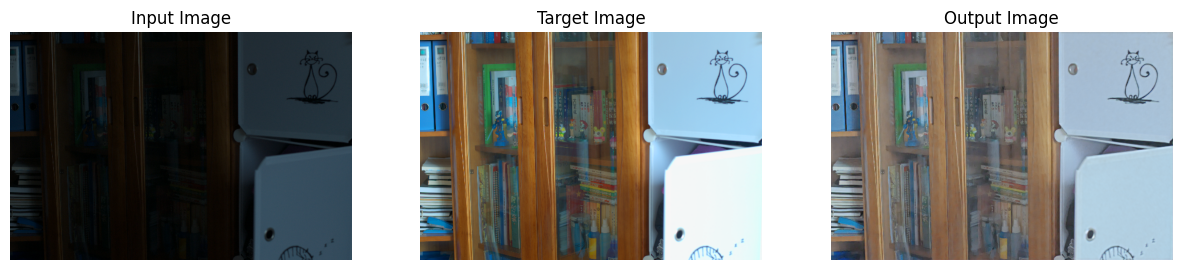

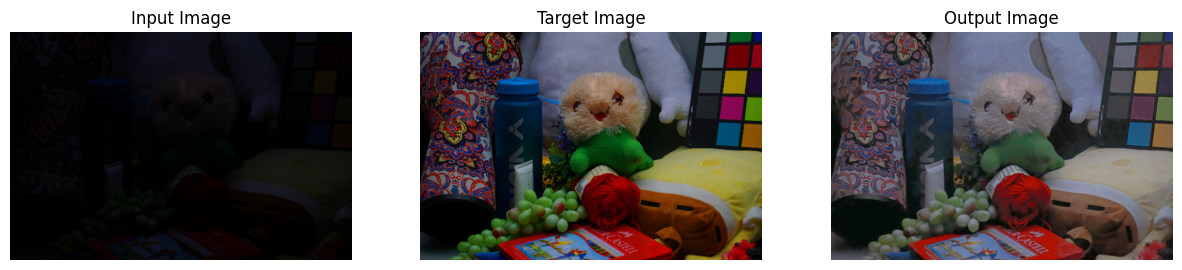

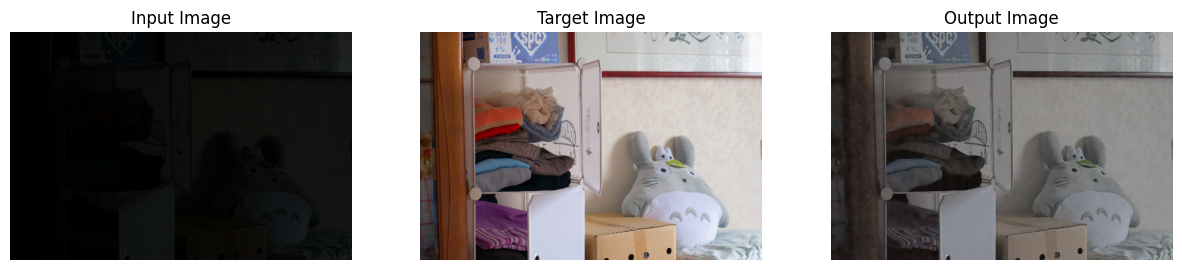

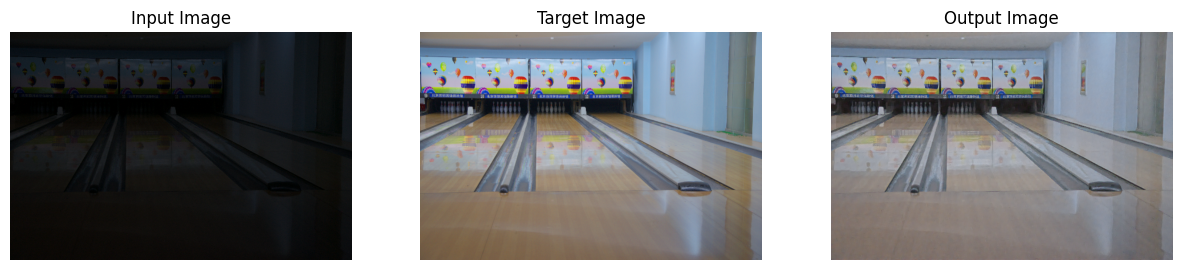

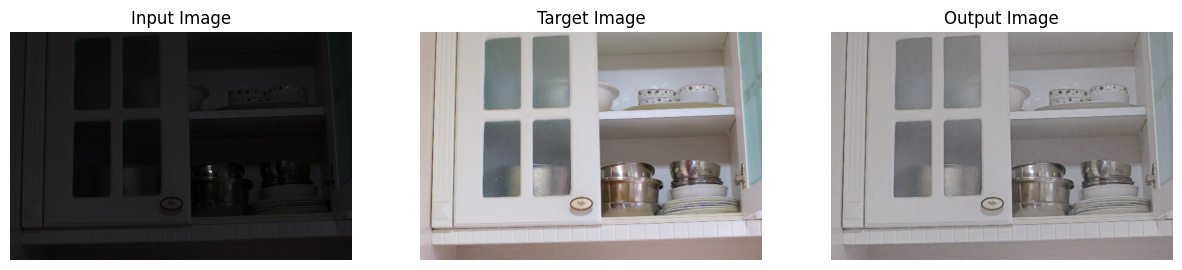

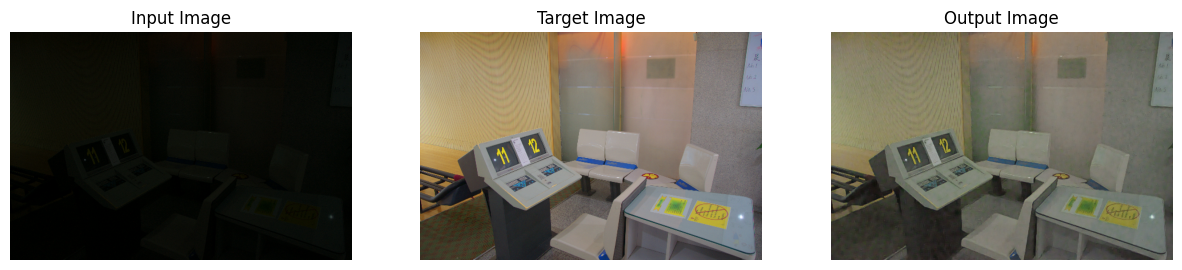

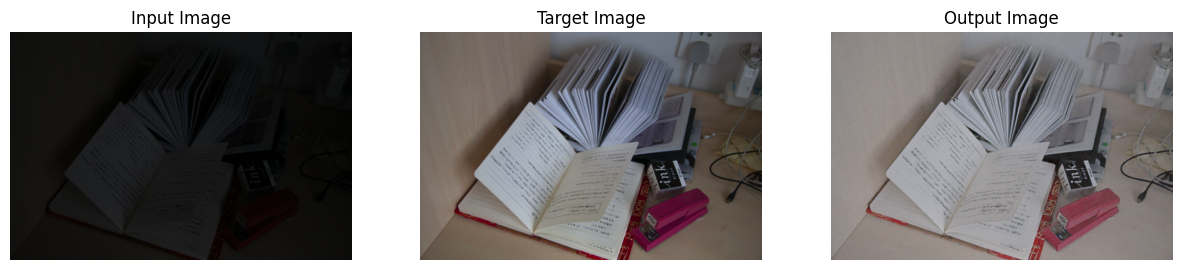

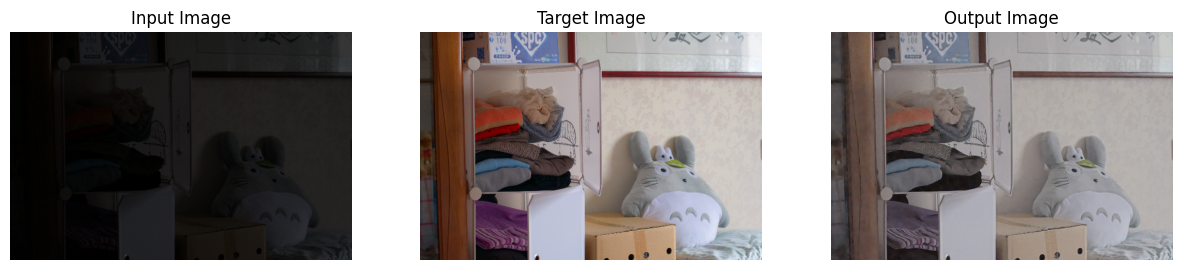

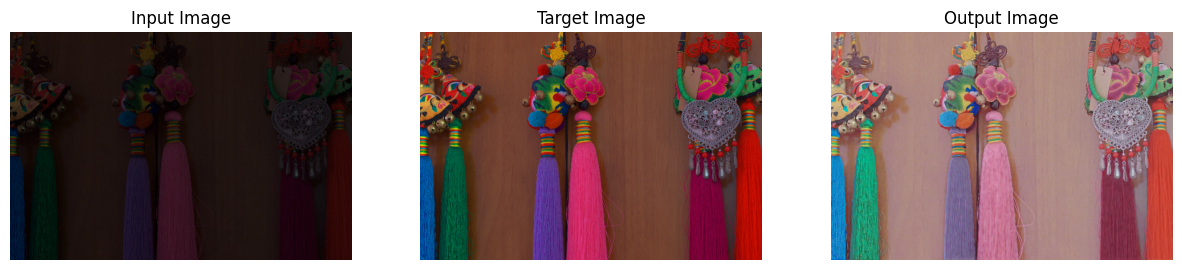

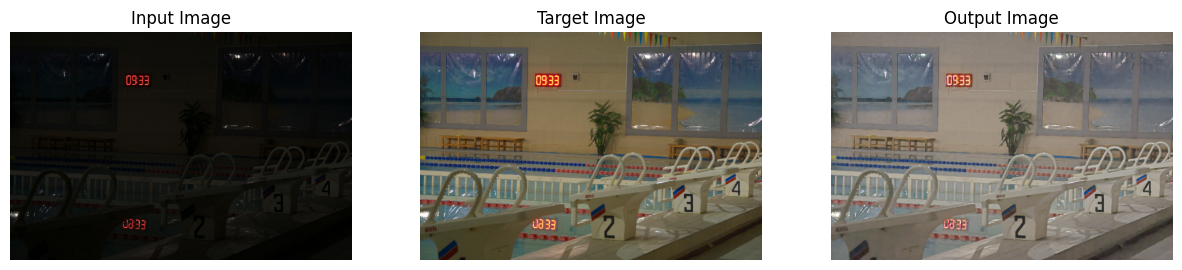

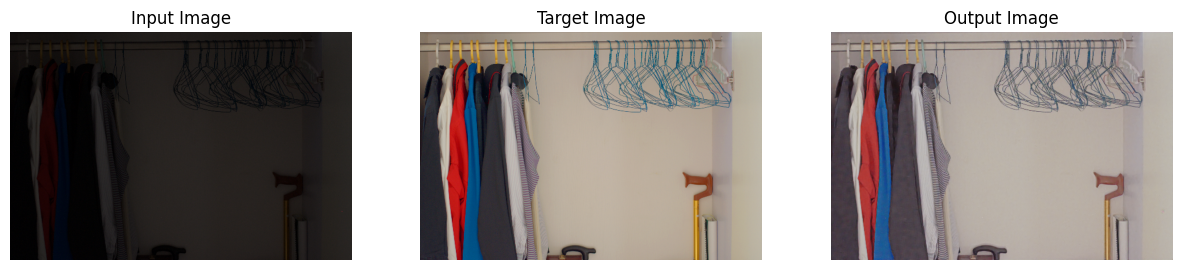

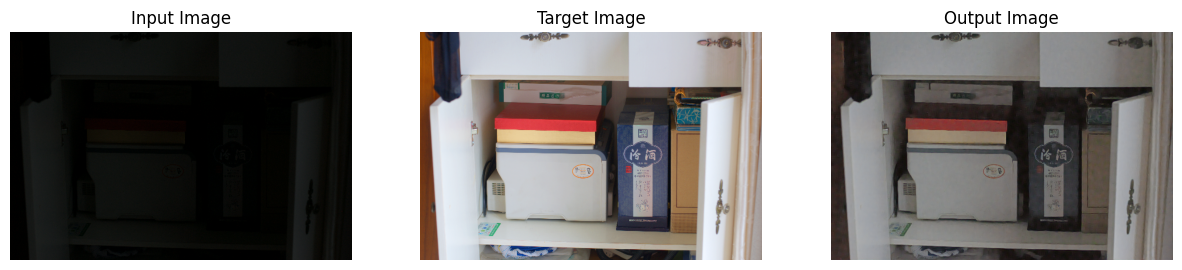

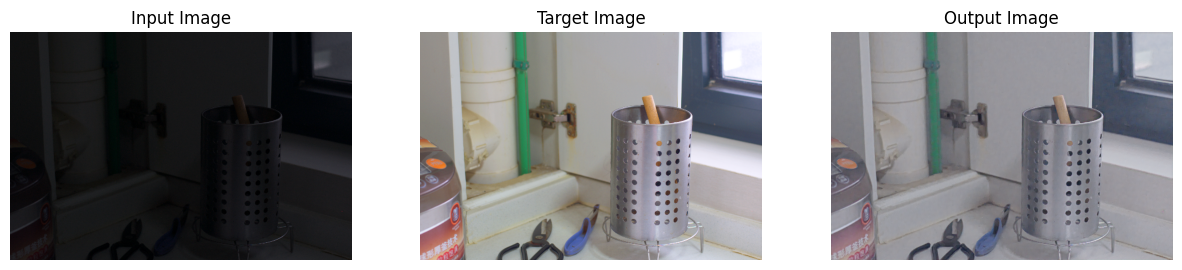

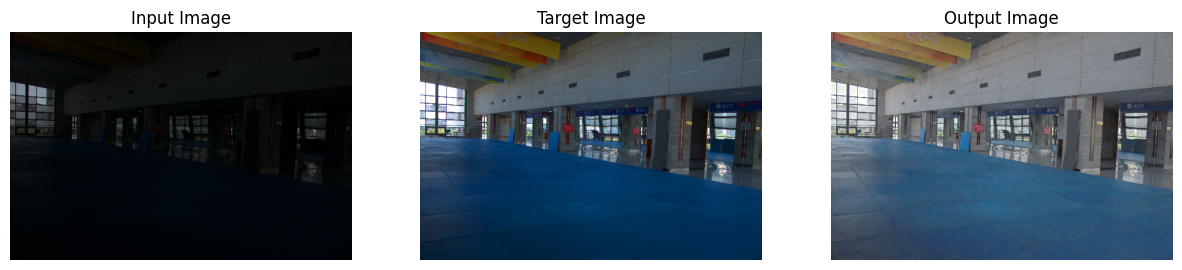

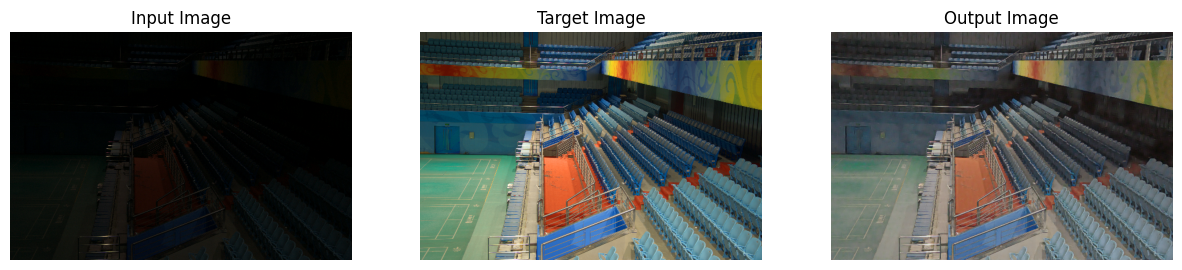

In [17]:
import matplotlib.pyplot as plt

# Function to display images side by side
def show_images(input_img, target_img, output_img):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_img.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Input Image")
    axes[1].imshow(target_img.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Target Image")
    axes[2].imshow(output_img.permute(1, 2, 0).detach().cpu().numpy())
    axes[2].set_title("Output Image")
    for ax in axes:
        ax.axis("off")
    plt.show()

# Testing on 10 images
model.eval()  # Set the model to evaluation mode


with torch.no_grad():
    
    for i, (input_img, target_img) in enumerate(t_dataloader):
        input_img, target_img = input_img.to(device), target_img.to(device)
        output_img = model(input_img)     
        show_images(input_img[0], target_img[0], output_img[0])


In [18]:
def evaluate_model_psnr(model, dataset, device, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    psnr_values = []
    with torch.no_grad():
        for i, (input_img, target_img) in enumerate(t_dataloader):
            if i == num_samples:
                break
            input_img, target_img = input_img.to(device), target_img.to(device)
            output_img = model(input_img)
            psnr = calculate_psnr(output_img, target_img)
            psnr_values.append(psnr)
            
    
    mean_psnr = np.mean(psnr_values)
    median_psnr = np.median(psnr_values)

    return mean_psnr, median_psnr, psnr_values

# Example usage:
# Assuming `model`, `dataset`, and `device` are already defined
mean_psnr, median_psnr, psnr_values = evaluate_model_psnr(model, dataset, device, num_samples=15)
print(f"Mean PSNR: {mean_psnr}")
print(f"Median PSNR: {median_psnr}")
print(f"Min PSNR:{np.min(psnr_values)}")
print(f"Max PSNR:{np.max(psnr_values)}")


Mean PSNR: 19.134746042887368
Median PSNR: 19.11049461364746
Min PSNR:12.264968872070312
Max PSNR:24.77850341796875
